# 集成学习


## 个体与集成

**集成学习（ensemble learning）通过构建并结合多个学习器来完成学习任务**，有时也被称为多分类器系统（multi-classifier system）、基于委员会的学习（committee-based learning）。

下图显示出集成学习的一般结构：

![集成学习示意图](images/ensemblelearning/集成学习示意图.png)

- 先产生一组“个体学习器”（individual learner）；
- 再用某种策略将它们结合起来。

个体学习器通常有一个现有的学习算法从训练数据产生，例如C4.5决策树算法、BP神经网络算法等，此时集成中只包含同种类型的个体学习器。例如“决策树集成”中全是决策树，“神经网络集成”中全是神经网络，**这样的集成是“同质”的（homogeneous）**。同质集成中的个体学习器亦称为**“基学习算法”（base learning algorithm）**。

集成也可包含不同类型的个体学习器，例如同时半酣决策树和神经网络，这样的集成是**“异质集成”（heterogeneous）**。异质集成中的个体学习器由不同的学习算法生成，这时就不再有基学习算法；相应地，个体学习器一般不称为基学习器，常称为**“组件学习器”（component learner）**或称为个体学习器。

**集成学习通过将多个学习器进行结合，常可获得比单一学习器显著优秀的泛化性能。**

这对“弱学习器（weak learning）”尤为明显，因此集成学习的很多理论研究都是针对弱学习器进行的，而基学习器有时也被直接称为弱学习器。

> 弱学习器常指泛化性能略优于随机猜测的学习器，例如二分类问题上精度略高于50%的分类器

虽然，理论上使用弱学习器集成足以获得好的性能，但在实践中出于种种考虑，人们往往会使用比较强的学习器。

一般情况下，好坏参杂时得到的结果会比坏的好一点，好的差一点，那么集成学习是怎么获得好性能的？

**事实上，集成学习中的个体学习器要“好而不同”，即个体学习器要有一定的“准确性”，不能太坏，并且要有“多样性”（diversity），即学习器间具有差异。**

下面做简单的分析：

考虑二分类问题$ y \in \{ -1,+1\}$和真实函数f，假定基分类器的错误率为$\epsilon$，即对每个基分类器$h_i$有：

$P(h_i(x) \neq f(x)) = \epsilon $  ——式（1）

假设集成通过简单投票法结合T（为讨论简单，T为奇数）个基分类器，若有超过半数的基分类器正确，则集成分类就正确：

$H(x) = sign(\sum_{i=1}^{T}h_i(x))$ ——式（2）

假定基分类器的错误率为相互独立，则由Hoeffding不等式可知，集成的错误率为：

$P(H(x) \neq f(x)) = \sum_{k=0}^{\lfloor T/2 \rfloor}(_k^T)(1-\epsilon)^k \epsilon ^{T-k} \leq exp(-\frac{1}{2}T(1-2\epsilon)^2)$ ——式（3）

上式显示出，**随着集成中个体分类器数目T的增大，集成学习器的错误率将指数级下降，最终趋向于零。**



然而我们必须注意到，**上面的分析有一个关键假设：基学习器的误差相互独立。**

在现实任务中，个体学习器是为解决同一个问题训练出来的，它们显然不可能相互独立！

事实上，个体学习器的“准确性”和“多样性”本身就存在冲突。一般的，准确性很高之后，要增加多样性就需要牺牲准确性。事实上，**如何产生并结合“好而不同”的个体学习器，恰是集成学习研究的核心。**

根据个体学习器的生成方式，目前的集成学习方法大致可以分类两类：

- 个体学习器间存在强依赖关系、必须串行生成的序列化方法；
- 个体学习器间不存在强依赖关系、可同时生成的并行化方法。

前者的代表是Boosting，后者的代表是Bagging和随机森林（Random Forest）。


## Boosting

Boosting是一组可将弱学习器提升为强学习器的算法。

这族算法的工作机制类似：

- 先从初始训练集训练出一个基学习器；
- 再根据基学习器的表现对训练样本分布进行调整，使得先前基学习器做错的训练样本在后续受到更多关注；
- 然后基于调整后的样本分布来训练下一个基学习器；
- 如此重复进行，直至基学习器数目达到事先指定的值T；
- 最终，将这T个基学习器进行加权结合。

Boosting族算法最著名的代表是AdaBoost[Freund and Schapire, 1997]，其描述如下图所示，其中$ y \in \{ -1,+1\}$，f是真实函数。

![AdaBoost算法](images/ensemblelearning/adaboost算法.PNG)


## sklearn中AdaBoost算法应用



### 分类问题

为了形成对比，首先来看使用sklearn中的决策树分类器对鸢尾花数据进行分类的结果：

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X_train,X_test,y_train,y_test = train_test_split(iris.data,iris.target)
# 使用决策树模型对X,y进行拟合，即生成决策树分类器
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
print("决策树模型：")
print(clf)
print("预测结果：",clf.predict(X_test))
print("真实结果：",y_test)
print("预测得分：",clf.score(X_test,y_test))

# 或者直接使用交叉验证方法进行测试，交叉验证折叠数k=10
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print("交叉验证评分：",scores.mean())

决策树模型：
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
预测结果： [1 2 1 2 2 2 0 0 1 1 0 1 1 1 2 0 0 2 0 0 2 1 0 0 0 1 0 0 2 1 2 2 0 0 0 0 1
 2]
真实结果： [1 2 1 2 2 2 0 0 2 1 0 1 1 1 2 0 0 2 0 0 2 1 0 0 0 1 0 0 2 2 2 2 0 0 0 0 1
 2]
预测得分： 0.9473684210526315
交叉验证评分： 0.96


**再来看AdaBoostClassifier分类器**

sklearn中的sklearn.ensemble.AdaBoostClassifier有如下参数：

- base_estimator ： object，optional（default = None）

用于定义基础学习器器。默认为None，这意味着基础学习器为DecisionTreeClassifier(max_depth=1)

- n_estimators ： 整数，可选（默认= 50）

用于定义基学习器的最大个数。在完美契合的情况下，学习过程提前停止。

- learning_rate ： float，optional（默认= 1。）

用于定义学习率，它会缩小每个分类器的贡献s。

- algorithm ： {'SAMME'，'SAMME.R'}，可选（默认='SAMME.R'）

SAMME表示离散的增强算法
SAMME.R表示连续的增强算法,SAMME.R算法通常比SAMME快收敛，通过较少的增强迭代实现较低的测试误差。

- random_state ： int，RandomState实例或None，可选（默认=无）
用于定义随机化参数。

下面的例子使用了100个弱学习器，构建强的集成学习器。

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

iris = load_iris()
clf = AdaBoostClassifier( )
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print("交叉验证评分：",scores.mean()) 

交叉验证评分： 0.9533333333333334


### 回归问题

在sklearn中，用于回归的AdaBoost模型是AdaBoostRegressor。它默认使用的回归类也为决策树回归器。

In [49]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/stock/600519.csv",header = 0)
y_mean,y_std = df.iloc[:,-1].mean(),df.iloc[:,-1].std()

X_scaled = preprocessing.scale(df.iloc[:,1:-1],axis = 0)
y_scaled = preprocessing.scale(df.iloc[:,-1],axis = 0)

X_train,X_test,y_train,y_test = train_test_split(X_scaled,y_scaled)

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train, y_train)  

print("模型实例：",regr)
print("模型中各特征权重：",regr.feature_importances_ ) 

print("收盘价真值为：{}".format((y_mean+y_test*y_std)[:10])) 
print("收盘价预测值为：{}".format((y_mean+regr.predict(X_test)*y_std)[:10]))
from sklearn.metrics import mean_squared_error
print("均方误差为{}".format(mean_squared_error(y_test,regr.predict(X_test))))


模型实例： AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=100, random_state=0)
模型中各特征权重： [2.94047466e-01 7.15859353e-02 2.69118201e-02 2.08426279e-03
 1.69799610e-04 5.62748534e-04 6.04637968e-01]
收盘价真值为：[758.67691196 484.82197974 565.64836692 490.7668626  474.27331553
 659.24524322 948.28264564 746.62701471 347.88950951 732.11509526]
收盘价预测值为：[746.56696539 483.64294681 574.15462631 478.48344021 483.64294681
 677.17643264 887.60434566 731.95280812 345.8769474  737.07534586]
均方误差为0.008275995459000379


## Bagging 与随机森林

由之前的综述可知，欲得到泛化性能强的集成，集成中的个体学习器应尽可能相互独立；虽然“独立”在现实任务中无法做到，但可以设法使基学习器尽可能具有较大差异。

给定一个训练数据集，一种可能的做法是对训练样本进行采样，产生出若干个不同的子集，再从每个数据子集中训练出一个基学习器。

然而，为了获得好的集成，我们同时还希望个体学习器不能太差。如果采样出的每个子集都完全不同，则每个基学习器只用到了一小部分训练数据，甚至不足以进行有效学习，这显然无法确保产生出比较好的基学习器。

为了解决上述问题，我们可以考虑使用相互有交叠的采样子集。

### Bagging

Bagging是并行式集成学习方法最著名的代表。从名字可以看出，它基于自助采样法（bootstrap sampling）。

给定包含m个样本的数据集，我们先随机取出一个样本放入采样集中，再把样本放回初始数据集，使得下次采样时该样本仍有可能被选中，这样，经过m次随机采样操作，我们得到含m个样本的采样集，初始训练集中有的样本在采样集里多次出现，有的则从未出现。根据自助采样法中的讨论，初始训练集中约有63.2%的样本出现在采样集中。

照这样，我们可采样出T个含m个训练样本的采样集，然后基于每个采样集训练出一个基学习器，再将这些基学习器进行组合。这就是Bagging的基本流程。

再对预测输出进行结合时，Baging通常对分类任务使用简单投票法（少数服从多数),对回归任务使用简单平均法。

若分类预测时出现两个类收到同样票数的情形，则最简单的做法就是随机选择一个，也可进一步考查学习器投票的置信度来确定最终胜者。

![Bagging算法](images/ensemblelearning/Bagging算法.PNG)

假定基学习器的计算复杂度为O(m),则Bagging的复杂度大致为$T(O(m) + O(s)$，考虑到采样与投票/平均过程的复杂度$O(s)$很小，而T通常是一个不太大的常数，因此训练一个Baaging集成与直接使用基学习器算法训练一个学习器的复杂度同阶，这说明Bagging是一个很高效的集成学习算法。另外，与标准AdaBoost只适用于二分类任务不同，Bagging能不经修改的用于分类、回归任务。

值得一提的是，自助采用过程还给Bagging带来了另一个优点：由于每个基学习器只使用了初始训练集中的约63.2%的样本，剩下约36.8%的样本可用作验证集来对泛化性能进行“包外估计”（out-of-bag estimate）。为此需记录每个基学习器所使用的训练样本。


### 随机森林

随机森林（Random Forest）是Bagging的一个扩展变体。RF在以决策树为基学习器构建Bagging集成的基础上，进一步在决策树的训练过程中引入了随机属性选择。

具体来说，传统决策树在选择划分属性时是在当前节点的属性集合（假定有d个属性）中选择一个最优属性；

而在RF中，对基决策树的每个节点，先从该节点的属性集合中随机选择一个包含k个属性的子集，然后再从这个子集中选择一个最优属性用于划分。这里的参数k控制了随机性的引入程度：若令k = d，则及决策树的构建与传统决策树相同；若令k=1，则是随机选择一个属性用于划分；一般情况下，推荐$k=log_2d$。

随机森林简单、容易实现、计算开销小，令人惊奇的是，它在很多现实任务中展现出强大的学习性能，被誉为“代表集成学习技术水平的方法”。

可以看出，随机森林对Bagging只做了小改动，但是与Bagging中基学习器的“多样性”仅通过样本扰动（对初始训练集采样）而不同，随机森林中基学习器不仅来自样本扰动，还来自属性扰动，这就使得最终集成的泛化性能可通过个体学习器之间的差异度的增加而进一步提升。

随机森林的收敛性与Bagging相似。下图所示，随机森林的起始性能往往相对较差，特别是集成中只包含一个基学习器时。

![在两个UCI数据上集成规模对随机森林与Bagging的影响](images/ensemblelearning/在两个UCI数据上集成规模对随机森林与Bagging的影响.PNG)

这很容易理解，因为通过引入属性扰动，随机森林中个体学习器的性能往往有所降低。然而，随着个体学习器数目的增加，随机森林通常会收敛到更低的泛化误差。值得一提的是，随机森林的训练效率常优于Bagging，因此在个体决策树的构建过程中，Bagging使用的是“确定性”决策树，在选择划分属性时要对结点的所有属性进行考察，而随机网络使用的是“随机性”决策树，则只需考察一个属性的子集。

## sklearn中的随机森林算法

### 分类问题

sklearn中有两种基于随机化决策树的平均化算法：

- 随机森林算法RandomForest
- Extra-Trees算法

它们都可以用于分类和回归

> scikit-learn实现通过平均其概率预测来组合分类器，而不是让每个分类器对单个类别进行投票。

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
   
X_train,X_test,y_train,y_test 
   = train_test_split(iris.data,iris.target,test_size=0.2)

    
# 使用决策树模型对X,y进行拟合，即生成决策树分类器
clf = RandomForestClassifier(n_estimators =100)
clf.fit(X_train, y_train)
print("随机森林模型：")
print(clf)
print("预测结果：",clf.predict(X_test))
print("真实结果：",y_test)
print("预测得分：",clf.score(X_test,y_test))

# 或者直接使用交叉验证方法进行测试，交叉验证折叠数k=5
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print("交叉验证评分：",scores.mean())


随机森林模型：
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
预测结果： [0 1 0 1 1 1 1 0 1 0 0 0 2 1 1 2 1 0 1 1 2 1 1 1 1 2 1 0 1 1 0 0 2 2 0 0 0
 2]
真实结果： [0 1 0 1 1 1 1 0 1 0 0 0 2 1 1 2 1 0 1 1 2 1 1 2 1 2 1 0 1 1 0 0 2 2 0 0 0
 2]
预测得分： 0.9736842105263158
交叉验证评分： 0.96


### 回归问题

sklearn中随机森林的回归器是 RandomForestRegressor

In [54]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/stock/600519.csv",header = 0)
y_mean,y_std = df.iloc[:,-1].mean(),df.iloc[:,-1].std()

X_scaled = preprocessing.scale(df.iloc[:,1:-1],axis = 0)
y_scaled = preprocessing.scale(df.iloc[:,-1],axis = 0)

X_train,X_test,y_train,y_test = train_test_split(X_scaled,y_scaled)

regr = RandomForestRegressor(n_estimators=100)
regr.fit(X_train, y_train)  

print("模型实例：",regr)
print("模型中各特征权重：",regr.feature_importances_ ) 

print("收盘价真值为：{}".format((y_mean+y_test*y_std)[:10])) 
print("收盘价预测值为：{}".format((y_mean+regr.predict(X_test)*y_std)[:10]))
from sklearn.metrics import mean_squared_error
print("均方误差为{}".format(mean_squared_error(y_test,regr.predict(X_test))))

模型实例： RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
模型中各特征权重： [1.03305717e-01 5.54048565e-02 6.00790298e-02 7.78604478e-04
 6.71313648e-04 1.30946132e-03 7.78451017e-01]
收盘价真值为：[480.14814085 477.86626662 970.31073854 481.17898754 742.14333201
 667.0716715  341.26406767 738.99074261 319.77641868 708.24548984]
收盘价预测值为：[481.97764352 475.13401295 938.18054823 492.18536936 751.50505465
 673.83802908 345.57310693 728.51063472 319.59607055 707.91308348]
均方误差为0.005207535450193888


## scikit中几个分类器的比较

下面例子的要点是说明不同分类器的决策边界的性质。

当然结果不能全信，数据集不同，分类器的性能也不相同。

特别是在高维空间中，数据可以更容易地线性分离。

诸如朴素贝叶斯和线性SVM之类的分类器比较简单，但它们可能比其他分类器有更好的泛化。

下列图表显示纯色训练点和半透明测试点。右下角显示了测试集的分类准确性。

> 下面例子中的数据是由scikit-learn生成的随机数据。
> 常用的API有：
> 1) 用make_regression 生成回归模型的数据
> 2) 用make_hastie_10_2 生成10属性的二分类数据集；
     make_classification生成单标记多分类数据集；
     make_multilabel_classification生成多标记多分类数据集
> 3) 用make_blobs生成聚类模型数据
> 4) 用make_gaussian_quantiles生成分组多维正态分布的数据
> 5）用make_circle生成圆圈形状的二维样本.factor表示里圈和外圈的距离之比.每圈共有n_samples/2个点
> 6) 用make_moom生成半环形图

X 示例 [[-1.04948638  0.8786438 ]
 [ 0.8780991   0.89551051]
 [ 0.95928819  1.03967316]
 [-1.18013412  1.12062155]
 [-0.90731836  1.06040861]
 [-0.62754626  1.37661405]
 [ 0.82178321  1.18947778]
 [-1.20376927  0.78801845]
 [ 0.77151441  0.345716  ]
 [-0.493857    1.66752297]]
y 示例 [1 0 0 1 1 1 0 1 0 1]


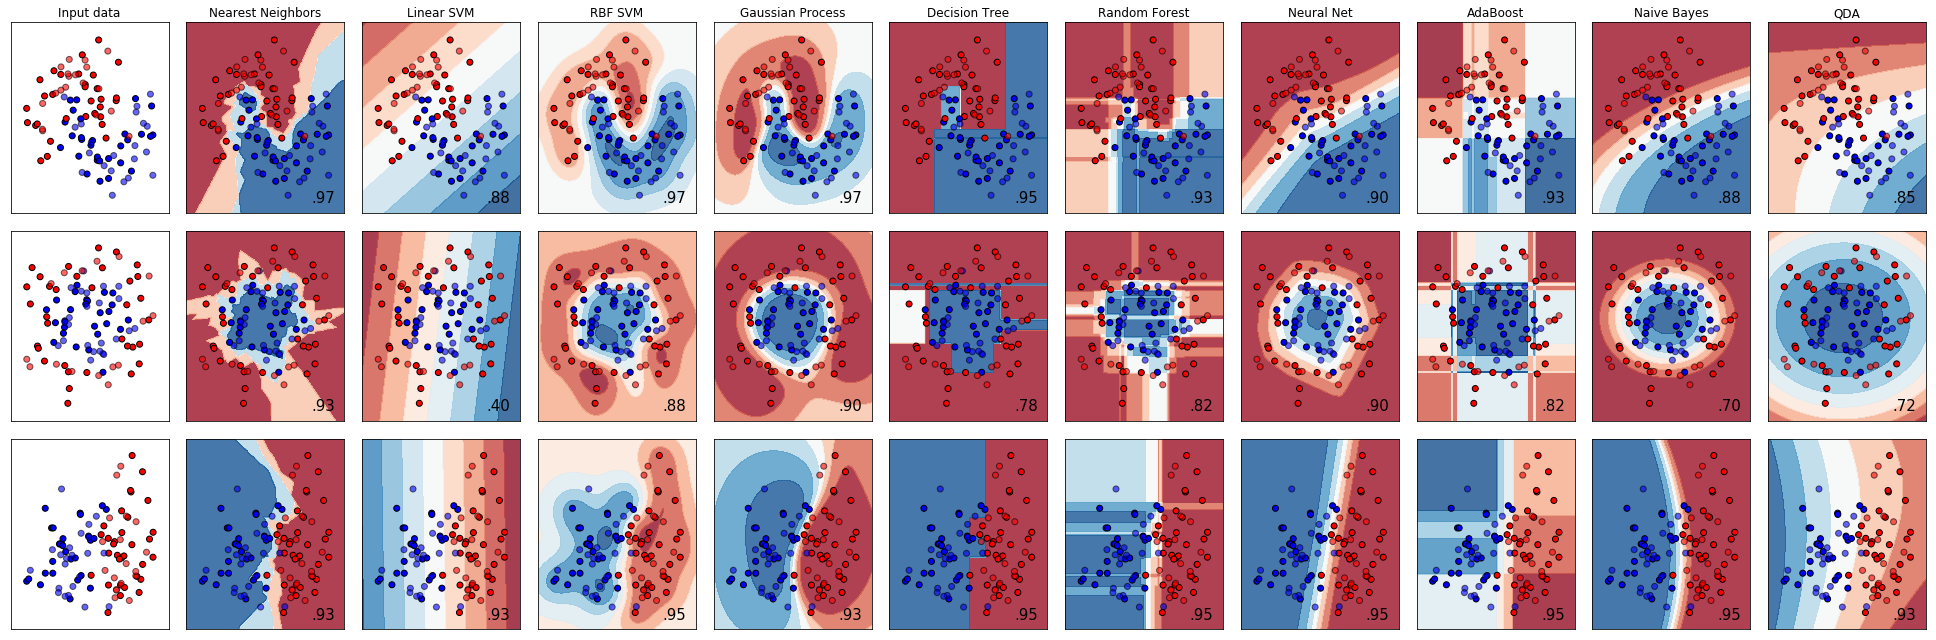

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
print("X 示例",X[:10])
print("y 示例",y[:10])

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)#均匀分布
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # 循环时，ds_cnt依次取0，1，2.即序号
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)# 归一化
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42) # 划分为训练集与测试集
    
    # 确定最大值、最小值，准备合适的坐标系
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
#plt.show()
plt.savefig("D:/classifiercompare.png")